# Recommender Systems - First steps

<small><i>Updated January 2022</i></small>

<div class="alert alert-info" style = "border-radius:10px;border-width:3px;border-color:darkblue;font-family:Verdana,sans-serif;font-size:16px;">
<h2>Outline</h2>
<ol>
    <li>What is a recommender system?</li>
    <li>How to build a recommender system?</li>
    <li>How to evaluate its success?</li>
</ol>
</div>

## What is a recommender system?

<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">
Recommender systems are ML-based techniques designed for interacting with large and complex information spaces, and for automatically providing information or items that are likely to be of interest to the user.

Some examples:
    
<table><tr>
    <td><h5>Amazon:</h5>
        <img src=http://3.bp.blogspot.com/_skxW9kDLt_c/TLfnLNnlnmI/AAAAAAAAfY0/HLqtnI3tItM/s1600/recommender.PNG width=400/></td>
    <td><h5>NetFlix:</h5>
        <img src=https://dataaspirant.files.wordpress.com/2015/01/netflixrec01_616.jpg width=400/></td>
</tr><tr>   
    <td><h5>Spotify:</h5>
        <img src="https://hackernoon.com/hn-images/0*zl0-pZtZzslGC-R8." width=400/></td>
    <td><h5>Linkedin: </h5>
        <img src=https://dataaspirant.files.wordpress.com/2015/01/linkedin.png width=400/></td>
</tr><tr>   
    <td><h5>Facebook (I):</h5>
        <img src=https://dataaspirant.files.wordpress.com/2015/01/8027583588_0232c7d836_z.jpg width=400/></td>
    <td><h5>Facebook (II): </h5>
        <img src=https://isenbergmarketing.files.wordpress.com/2015/02/marks_year.jpg width=400/></td>
</tr></table>

</div>

<div class="alert alert-error" style = "border-radius:10px;border-width:3px;border-color:darkred;font-family:Verdana,sans-serif;font-size:14px;">


<h3>Why do we use recommender systems?</h3>
<ul>
<li>To filter large amounts of data</li>
<li>To reduce cognitive load on users</li>
<li>To discover new *things*</li>
</ul>
</div>



<div class="alert alert-success" style = "border-radius:10px;border-width:3px;border-color:darkgreen;font-family:Verdana,sans-serif;font-size:16px;">

<h3>Which data do RecSys need to operate?</h3>
<ul>
    <li>Data describing items, users, users' preferences on items, etc.</li>
    <li>Data can be explicit (rating, reviews) or implicit (navigation, purchases, ...).</li>
    <li>Other general information such as demographics or problem specific characteristics might be important, too.</li>
    <li>Note that most of these are dynamic: taste or preferences, items' characteristics, etc.</li>
</ul>
</div>





## Steps to build a recommender system:
<ol>
    <li>Data collection and understanding</li>
    <li>Data filtering/cleaning</li>
    <li>Learning<br>
        <span style="font-size:smaller">E.g., using item/user similarity function</span></li>
    <li>Evaluation</li>
</ol>


<hr>

# Hands-on

Let us load the libraries that we are going to use:

In [2]:
%autosave 150
%matplotlib inline
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import os
import scipy.stats
import statistics
import math 

Autosaving every 150 seconds


and the dataset that we want to explore, the Movielens dataset:

In [3]:
import urllib.request
import zipfile
filename = "ml-100k.zip"
if not os.path.isfile(filename):
    urllib.request.urlretrieve('https://files.grouplens.org/datasets/movielens/ml-100k.zip',filename)
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(".")

If it didn't dowload, you can <a href="https://grouplens.org/datasets/movielens/100k/">find it here</a>.

# Understanding the data

Now, we can start exploring the dataset:

In [4]:
# The dataset is composed of 3 main files

# The users file 
u_cols = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols)

# The movies (items) file
m_cols = ['movie_id', 'title', 'release_date']
# It contains aditional columns indicating, among other the movies' genre.
# Let's only load the first three columns:
movies = pd.read_csv('ml-100k/u.item', sep='|', names=m_cols, usecols=range(3), encoding='latin-1')

# The ratings file 
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols)


# We merge all three dataframes into a single dataset
data = pd.merge(pd.merge(ratings, users), movies)
# and keep only the columns that we are going to use
data = data[['user_id', 'rating', 'movie_id', 'title', 'release_date', 'gender', 'age']]


print("The BD has ", data.shape[0], " ratings")
print("The BD has ", data.user_id.nunique(), " users")
print("The BD has ", data.movie_id.nunique(), " movies")
print(data.head())

The BD has  100000  ratings
The BD has  943  users
The BD has  1682  movies
   user_id  rating  movie_id         title release_date gender  age
0      196       3       242  Kolya (1996)  24-Jan-1997      M   49
1      305       5       242  Kolya (1996)  24-Jan-1997      M   23
2        6       4       242  Kolya (1996)  24-Jan-1997      M   42
3      234       4       242  Kolya (1996)  24-Jan-1997      M   60
4       63       3       242  Kolya (1996)  24-Jan-1997      M   31


We might be interested in recovering the set of movies rated by user number '1':

In [5]:
data[data.user_id==1].head(10) # Show the first 5 ratings of user 1

,user_id,rating,movie_id,title,release_date,gender,age
14,1,5,242,Kolya (1996),24-Jan-1997,M,24
417,1,4,251,Shall We Dance? (1996),11-Jul-1997,M,24
708,1,3,67,Ace Ventura: Pet Detective (1994),01-Jan-1994,M,24
940,1,4,238,Raising Arizona (1987),01-Jan-1987,M,24
1306,1,5,111,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,M,24
1618,1,4,25,"Birdcage, The (1996)",08-Mar-1996,M,24
2363,1,2,94,Home Alone (1990),01-Jan-1990,M,24
2677,1,1,8,Babe (1995),01-Jan-1995,M,24
3073,1,3,70,Four Weddings and a Funeral (1994),01-Jan-1994,M,24
3304,1,4,66,While You Were Sleeping (1995),01-Jan-1995,M,24


We can also obtain the mean rating given by user '1':

In [6]:
for i in range(1,10):
    rating = data[data.user_id==i].rating.mean()
    print(f'The mean rating for the user {i} is: {rating}')


The mean rating for the user 1 is: 3.610294117647059
The mean rating for the user 2 is: 3.7096774193548385
The mean rating for the user 3 is: 2.7962962962962963
The mean rating for the user 4 is: 4.333333333333333
The mean rating for the user 5 is: 2.874285714285714
The mean rating for the user 6 is: 3.6350710900473935
The mean rating for the user 7 is: 3.965260545905707
The mean rating for the user 8 is: 3.7966101694915255
The mean rating for the user 9 is: 4.2727272727272725


Changing the focus, we might be interested in finding the mean rating of a movie (e.g., "Seven"):

In [7]:
data.rating[data.title=="Seven (Se7en) (1995)"].mean()

3.847457627118644

These are the 10 most rated movies, that is, the movies which have been rated more frequently:

In [8]:
data.groupby('title').size().sort_values(ascending=False).head(10)

title
Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
dtype: int64

This is probably related with the most commonly seen movies. 

<div class="alert alert-success">
Question #1.-<br>
<span style="color:black">Can we consider this list as a recommender?
Do you know any popular app using this kind of list as a recommender? <br/><br/>

#### Depend, because this is the list where have been rated more frequently, that means that can ba good or bad, in this case we know that this movies have many information, because provide to us wich are the most popular in good sense and which not.We can use this information if we have an hybrid system, we can use these movies and customize the recomendation for each user. ####

</span></div>

Now, let's find the top-10 movies according to their mean score:

In [9]:
data.groupby('title').rating.mean().sort_values(ascending=False).head(10)

title
They Made Me a Criminal (1939)                       5.0
Marlene Dietrich: Shadow and Light (1996)            5.0
Saint of Fort Washington, The (1993)                 5.0
Someone Else's America (1995)                        5.0
Star Kid (1997)                                      5.0
Great Day in Harlem, A (1994)                        5.0
Aiqing wansui (1994)                                 5.0
Santa with Muscles (1996)                            5.0
Prefontaine (1997)                                   5.0
Entertaining Angels: The Dorothy Day Story (1996)    5.0
Name: rating, dtype: float64

Do you agree with this list? Are the items in this list among the movies which are usually listed as the most liked ones?

Many of these items are rare movies, maybe good ones, but they have received few ratings. In a general public application, you might be interested in a list that combines frequently seen and highly rated movies. How to do that? Let's filter the raking by the number of ratings.

These are the top-10 movies according to their mean score, which have been rated by at least 50 users:

In [10]:
# number of ratings per movie
no_ratings = data.groupby('title').size()
# ranking of movies according to mean score
mean_score = data.groupby('title').rating.mean().sort_values(ascending=False)
# filter out movies with no more than 50 ratings
mean_score[no_ratings>50].head(10)

title
Close Shave, A (1995)                                     4.491071
Schindler's List (1993)                                   4.466443
Wrong Trousers, The (1993)                                4.466102
Casablanca (1942)                                         4.456790
Wallace & Gromit: The Best of Aardman Animation (1996)    4.447761
Shawshank Redemption, The (1994)                          4.445230
Rear Window (1954)                                        4.387560
Usual Suspects, The (1995)                                4.385768
Star Wars (1977)                                          4.358491
12 Angry Men (1957)                                       4.344000
Name: rating, dtype: float64

OK, that's a solution, but which are the implications?

In [11]:
print("Only", np.sum(no_ratings>50), "out of", len(no_ratings), "movies have been considered.")

Only 596 out of 1664 movies have been considered.


Let's have a look to the histogram of movies as a function of the number of received ratings:

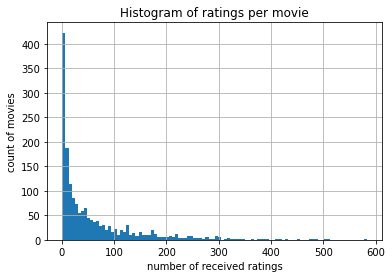

In [12]:
no_ratings = data.groupby('movie_id').size().sort_values(ascending=False)
no_ratings.hist(bins=100)
plt.title("Histogram of ratings per movie")
plt.ylabel('count of movies')
plt.xlabel('number of received ratings')
plt.show()

That is, most of the movies have received a low number of ratings. Remember the long tail distribution?

<div class="alert alert-success">
Question #2.-<br>
<span style="color:black">Out of curiosity, which are the movies that have received at least 400 ratings?</span></div>

In [13]:
#Question 2
# filter out movies with at least 400 ratings
no_ratings_movies = data.groupby('title').size()
most_ratings = mean_score[no_ratings_movies>400]
print(f'Only {most_ratings.shape} movies had at least 400 ratings or more, these are: {most_ratings}')

Only (12,) movies had at least 400 ratings or more, these are: title
Star Wars (1977)                  4.358491
Godfather, The (1972)             4.283293
Raiders of the Lost Ark (1981)    4.252381
Fargo (1996)                      4.155512
Return of the Jedi (1983)         4.007890
Toy Story (1995)                  3.878319
Contact (1997)                    3.803536
English Patient, The (1996)       3.656965
Air Force One (1997)              3.631090
Scream (1996)                     3.441423
Independence Day (ID4) (1996)     3.438228
Liar Liar (1997)                  3.156701
Name: rating, dtype: float64


Now we know that all the movies do not receive the same number of ratings. But, all the users rate with the same frequency?
<div class="alert alert-success">
Question #3.-<br>
<span style="color:black">
Show in a histogram with the number of given ratings (x-axis) against the number of users (y-axis)</span></div>

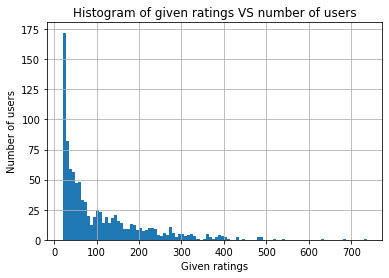

In [14]:
#Question 3

no_ratings_users = data.groupby('user_id').size().sort_values(ascending=False)
no_ratings_users.hist(bins=100)
plt.title("Histogram of given ratings VS number of users")
plt.ylabel('Number of users')
plt.xlabel('Given ratings')
plt.show()


That is, most of the users rate less than 60 movies, whereas few users rate more than 400 movies; the long tail distribution, again!

Similarly, one can expect that users behave differently: some people are more generous when providing a rating; others tend to be more difficult to content.

<div class="alert alert-success">
Question #4.-<br>
<span style="color:black">Show the mean given ratings of the first 10 users of the dataset.</span></div>

In [15]:
# Question 4
for i in range(1,11):
    rating = data[data.user_id==i].rating.mean()
    print(f'The mean rating for the user {i} is: {rating}')

The mean rating for the user 1 is: 3.610294117647059
The mean rating for the user 2 is: 3.7096774193548385
The mean rating for the user 3 is: 2.7962962962962963
The mean rating for the user 4 is: 4.333333333333333
The mean rating for the user 5 is: 2.874285714285714
The mean rating for the user 6 is: 3.6350710900473935
The mean rating for the user 7 is: 3.965260545905707
The mean rating for the user 8 is: 3.7966101694915255
The mean rating for the user 9 is: 4.2727272727272725
The mean rating for the user 10 is: 4.206521739130435


We are using all the time the mean function to obtain the average value of the ratings, but this is not the only aggregation function and might not be appropriate in presence of outliers or high variance. 

<div class="alert alert-success">
Question #5.-<br>
<span style="color:black">Show the 10 movies which have associated the most discordant ratings (you could use standard deviation to measure discordance). That is, find those movies that people do love or do hate.
</span></div>

In [559]:
# Question 5
stdev_movies = data.groupby('title').rating.std()
stdev_movies.sort_values(ascending=False).head(10)

title
Tough and Deadly (1995)                               2.828427
Delta of Venus (1994)                                 2.828427
The Deadly Cure (1996)                                2.828427
Hugo Pool (1997)                                      2.138090
Little City (1998)                                    2.121320
Convent, The (Convento, O) (1995)                     2.121320
American Dream (1990)                                 2.121320
Spirits of the Dead (Tre passi nel delirio) (1968)    2.121320
Visitors, The (Visiteurs, Les) (1993)                 2.121320
Rough Magic (1995)                                    2.121320
Name: rating, dtype: float64

In [438]:
#Another way but with different results
movies_title = data.title.unique()

StndDev_vector = []
for i in range(len(movies_title)):

    Peli = movies_title[i]
    guardarRating = data[data.title==Peli].rating

    if len(guardarRating)>2:
        df2 = ([[statistics.stdev(guardarRating), Peli]])
        #df2 = ([[statistics.stdev(guardarRating)]])
        StndDev_vector.append(df2)
    
    else:
        df2 = ([[0, Peli]])
        #df2 = ([[0]])
        StndDev_vector.append(df2)
StndDev_vector = sorted(StndDev_vector,reverse=True)
print(StndDev_vector[0:9])


[[[2.138089935299395, 'Hugo Pool (1997)']], [[2.081665999466133, 'For the Moment (1994)']], [[2.081665999466133, 'Boys, Les (1997)']], [[2.0, 'Mondo (1996)']], [[1.9148542155126762, 'Lay of the Land, The (1997)']], [[1.9148542155126762, 'Killer (Bulletproof Heart) (1994)']], [[1.9023794624226837, 'Aparajito (1956)']], [[1.8929694486000912, 'Two or Three Things I Know About Her (1966)']], [[1.8929694486000912, 'Leading Man, The (1996)']]]


## Crossing information with auxiliary features
Sometimes, we might be interested in segmenting our analysis according to some feature. In our dataset, we have several descriptive variables of both users and movies. For example, which is the age of our users?

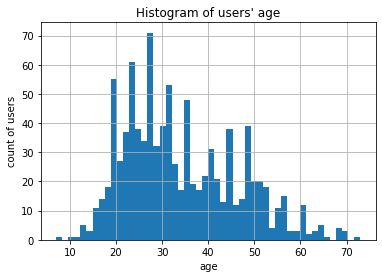

In [195]:
users.age.hist(bins=50)
plt.title("Histogram of users' age")
plt.ylabel('count of users')
plt.xlabel('age')
plt.show()

So, we might wonder if different age groups behave differently, on average. Let us see their mean ratings per age-group:

In [196]:
# We build age groups by discretizing the variable 'age' as follows:
labels_age = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']
data['age_group'] = pd.cut(data.age, range(0, 81, 10), right=False, labels=labels_age)

# Note that we are using two aggregation functions: size and mean
print(data.groupby('age_group').agg({'rating': [np.size, np.mean]}))

          rating          
            size      mean
age_group                 
0-9           43  3.767442
10-19       8181  3.486126
20-29      39535  3.467333
30-39      25696  3.554444
40-49      15021  3.591772
50-59       8704  3.635800
60-69       2623  3.648875
70-79        197  3.649746


We also have a variable that tells the year in which each movie was released. Many people say that classical movies are better than current ones. We might try to see the mean rating of the movies as time goes on:

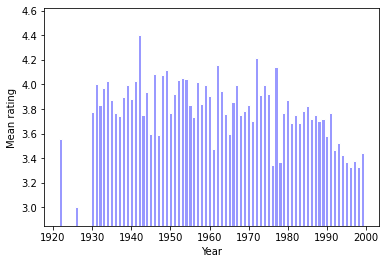

In [197]:
data['release_year'] = data['release_date'].apply(lambda x: int(str(x)[-4:]) 
                                                  if math.isnan(float(str(x)[-4:])) == False 
                                                  else 1999)
rank_per_year = data.groupby('release_year')['rating'].mean()
plt.bar(rank_per_year.keys(), rank_per_year, facecolor='#9999ff', edgecolor='white')
plt.xlabel("Year")
plt.ylabel("Mean rating")
plt.ylim((min(rank_per_year)*0.95,max(rank_per_year)*1.05))
plt.show()

But, again, the number of ratings received by movies released in different years is not the same:

In [198]:
# We build years groups by discretizing the variable 'release_year' as follows:
labels_year = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['year_group'] = pd.cut(data.release_year, range(1920, 2001, 10), right=False, labels=labels_year)

# Note that we are using two aggregation functions: size and mean
print(data.groupby('year_group').agg({'rating': [np.size, np.mean]}))

           rating          
             size      mean
year_group                 
20s            56  3.535714
30s          1496  3.925134
40s          2249  4.010671
50s          3506  3.937250
60s          3875  3.881548
70s          6242  3.866069
80s         12122  3.749794
90s         70454  3.398870


We could even try to observe the correlation between two variables. In this case, let's explore the mean rating by year of movie's release and user's age.

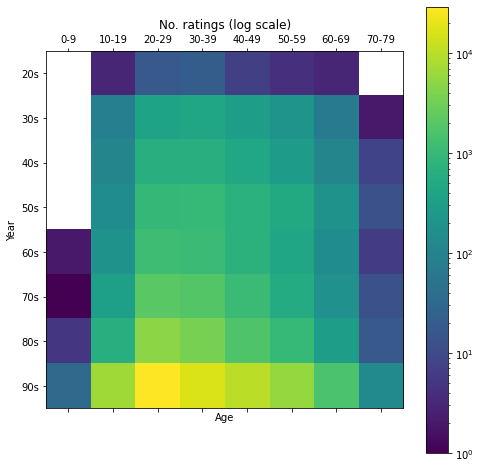

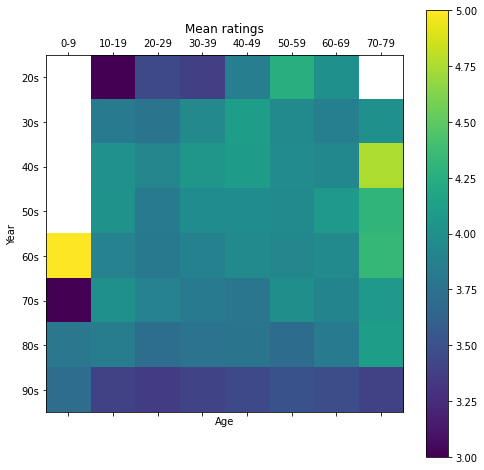

In [199]:
# show number of ratings
from matplotlib.colors import LogNorm
v = data.groupby(['year_group','age_group'])['rating'].size()
mat_size = v.values
mat_size.shape = (len(labels_year),len(labels_age))
plt.figure(figsize=(8,8))
plt.matshow(mat_size, norm=LogNorm(), fignum=1)
plt.colorbar()
plt.title("No. ratings (log scale)")
plt.xlabel("Age")
plt.ylabel("Year")
plt.xticks(np.arange(8), labels_age)
plt.yticks(np.arange(8), labels_year)
plt.show()

# show mean ratings
v = data.groupby(['year_group','age_group'])['rating'].mean()
mat_rating = v.values
mat_rating.shape = (len(labels_year),len(labels_age))
plt.figure(figsize=(8,8))
plt.matshow(mat_rating, fignum=1)
plt.colorbar()
plt.title("Mean ratings")
plt.xlabel("Age")
plt.ylabel("Year")
plt.xticks(np.arange(8), labels_age)
plt.yticks(np.arange(8), labels_year)
plt.show()

Now, let's focus on another interesting feature: gender.
<div class="alert alert-success">
Question #6.-<br>
<span style="color:black">Show the mean rating per gender for 10 movies with at least 50 ratings:</span></div>

In [517]:
# Question 6
#Here we choose the 10 movies with most at least 50 ratings for both gender
No_Rating = data.groupby(['title','gender']).size().reset_index(name='counts')
Range_Movies = No_Rating[No_Rating['counts']>=50].head(10)
gender_group_movie = data[data['title'].isin(Range_Movies.title)].groupby(['title','gender']).rating.mean()
print(f'This is the mean rating per gender for 10 movies with at least 50 ratings:\n {gender_group_movie}')



This is the mean rating per gender for 10 movies with at least 50 ratings:
 title                                gender
101 Dalmatians (1996)                F         3.116279
                                     M         2.772727
12 Angry Men (1957)                  F         4.269231
                                     M         4.363636
2 Days in the Valley (1996)          F         3.235294
                                     M         3.223684
20,000 Leagues Under the Sea (1954)  F         3.214286
                                     M         3.568966
2001: A Space Odyssey (1968)         F         3.491228
                                     M         4.103960
39 Steps, The (1935)                 F         4.000000
                                     M         4.060000
Absolute Power (1997)                F         3.451613
                                     M         3.343750
Abyss, The (1989)                    F         3.814815
                                     M  

<div class="alert alert-success">
Question #7.-<br>
<span style="color:black">Among these (movies with at least 50 ratings), which are the 10 best movies as rated by women?</span></div>

In [544]:
# Question 7

#In this part, I change the methodology for choose the 10 movies based only in the Female gender
Female_Movies = No_Rating[No_Rating['gender']=='F']
Range_F = Female_Movies[Female_Movies['counts']>=50].head(10)
F_group = data[data['title'].isin(Range_F.title)].groupby(['title','gender']).rating.mean()
print('Movies founded only based in the Female gender')
print(F_group)

Movies founded only based in the Female gender
title                         gender
2001: A Space Odyssey (1968)  F         3.491228
                              M         4.103960
Air Force One (1997)          F         3.690476
                              M         3.606557
Aladdin (1992)                F         3.949153
                              M         3.762500
Alien (1979)                  F         3.660714
                              M         4.123404
Aliens (1986)                 F         3.672727
                              M         4.013100
Amadeus (1984)                F         4.038961
                              M         4.211055
Apollo 13 (1995)              F         4.000000
                              M         3.909953
Babe (1995)                   F         4.050000
                              M         3.974843
Back to the Future (1985)     F         3.766667
                              M         3.857692
Beauty and the Beast (1991)   F   

In [545]:
#In this part, I change the methodology for choose the 10 movies based only in the Male gender
Male_Movies = No_Rating[No_Rating['gender']=='M']
Range_M = Male_Movies[Male_Movies['counts']>=50].head(10)
M_group = data[data['title'].isin(Range_M.title)].groupby(['title','gender']).rating.mean()
print('Movies founded only based in the Male gender')
print(M_group)

Movies founded only based in the Male gender
title                                gender
101 Dalmatians (1996)                F         3.116279
                                     M         2.772727
12 Angry Men (1957)                  F         4.269231
                                     M         4.363636
2 Days in the Valley (1996)          F         3.235294
                                     M         3.223684
20,000 Leagues Under the Sea (1954)  F         3.214286
                                     M         3.568966
2001: A Space Odyssey (1968)         F         3.491228
                                     M         4.103960
39 Steps, The (1935)                 F         4.000000
                                     M         4.060000
Absolute Power (1997)                F         3.451613
                                     M         3.343750
Abyss, The (1989)                    F         3.814815
                                     M         3.540323
Ace Ventura: Pe

You probably has already noticed a difference between the mean ratings of women and those of men. Now we wonder which movies have been rated more differently by men and by women.

<div class="alert alert-success">
Question #8.-<br>
<span style="color:black">Show the 10 movies with the largest difference between women's mean rating and men's.
</span></div>

In [570]:
# Question 8
#Here, we found the difference between Male and Female rating mean
Difference_F_M = data.groupby(['title','gender']).rating.std()
Difference_F_M.sort_values(ascending=False).head(10)

title                                                                            gender
Microcosmos: Le peuple de l'herbe (1996)                                         F         2.828427
The Deadly Cure (1996)                                                           M         2.828427
Turbo: A Power Rangers Movie (1997)                                              F         2.828427
For the Moment (1994)                                                            M         2.828427
Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996)  F         2.828427
Tough and Deadly (1995)                                                          M         2.828427
Mondo (1996)                                                                     M         2.828427
Braindead (1992)                                                                 F         2.828427
In the Bleak Midwinter (1995)                                                    F         2.309401
Bad Taste (1

In [574]:
#In this part we found the deviation for the movies with more than 50 rating per movie
gender_group_movie = data[data['title'].isin(Range_Movies.title)].groupby(['gender','title']).rating.std()
print(gender_group_movie.sort_values(ascending=False).head(10))

gender  title                            
F       Ace Ventura: Pet Detective (1994)    1.370107
M       Ace Ventura: Pet Detective (1994)    1.186738
F       101 Dalmatians (1996)                1.179372
        2001: A Space Odyssey (1968)         1.135826
        Abyss, The (1989)                    1.039121
M       Absolute Power (1997)                0.992902
        101 Dalmatians (1996)                0.989101
        2 Days in the Valley (1996)          0.987909
        2001: A Space Odyssey (1968)         0.953696
        Abyss, The (1989)                    0.877906
Name: rating, dtype: float64


In [573]:
diference = data[data['title'].isin(No_Rating.title)].groupby(['title','gender']).rating.mean()
diference.sort_values(ascending=False).head(10)

title                                       gender
Star Kid (1997)                             M         5.0
Telling Lies in America (1997)              F         5.0
Prefontaine (1997)                          M         5.0
Foreign Correspondent (1940)                F         5.0
Great Day in Harlem, A (1994)               M         5.0
Saint of Fort Washington, The (1993)        M         5.0
Everest (1998)                              F         5.0
Santa with Muscles (1996)                   M         5.0
Marlene Dietrich: Shadow and Light (1996)   M         5.0
Stripes (1981)                              F         5.0
Name: rating, dtype: float64